# Capstone Project: Social media sentiment analysis
## Part 5: Samsung stock prediction based on YouTube sentiments

In [1]:
# Import libraries
import requests
import json
import pandas as pd
import numpy as np
import time
import random
import re
import csv

from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error, roc_auc_score, roc_curve, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score,auc

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

C:\Users\frl\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


The focus of the project is on sentiment analysis and topic modeling. This part on stock price prediction is an additional idea. Given the focus of the project was not on stock price prediction, the previously scrapped Twitter and YouTube comments could only provide at most 40 days of sentiments. 

Major limitation: There is only 40-50 days of YouTube comments on Samsung. This means that there is only 40 data points for stock price train and test. 

In [36]:
youtube_samsung_sentiment=pd.read_csv('./dataset/youtube_samsung_sentiment.csv')

In [37]:
youtube_samsung_sentiment.head()

,comments,date,sentiment
0,😱😱😱so cool,2020-04-13T20:35:50.000Z,0.3182
1,Már bánom hogy megvettem! Retek szar exynos pr...,2020-04-13T18:07:07.000Z,0.4738
2,هاتف رائع,2020-04-13T15:51:08.000Z,0.0000
3,Whose watching this on an s20 ultra,2020-04-13T14:05:00.000Z,0.0000
4,samsung: ‘intelligent battery control’<br />ex...,2020-04-13T09:42:06.000Z,0.0000


In [5]:
# Convert the format of 'date' from yyyy-mm-dd(time) to dd/mm/yyyy. This is to merge with the stock price data later.
youtube_samsung_sentiment['date']=youtube_samsung_sentiment['date'].str[6:10]+'/'

In [6]:
newdate=[]
for i in range(youtube_samsung_sentiment.shape[0]):
    date=youtube_samsung_sentiment['date'][i][2:]+youtube_samsung_sentiment['date'][i][0]+'/2020'
    newdate.append(date)

In [7]:
youtube_samsung_sentiment['date']=newdate

In [8]:
for date in youtube_samsung_sentiment['date']:
    youtube_samsung_sentiment['date'] = youtube_samsung_sentiment['date'].apply(lambda x : x[1:] if x.startswith("0") else x)

In [9]:
# Get average sentiment for each day
youtube_samsung_sentiment_mean = pd.DataFrame(youtube_samsung_sentiment.groupby(['date'],as_index=False).mean())

In [38]:
youtube_samsung_sentiment_mean.head()

,date,sentiment
0,1/3/2020,0.013170
1,1/4/2020,0.288583
2,10/3/2020,0.256727
3,10/4/2020,0.346750
4,11/2/2020,0.101022


In [11]:
# Samsung Electonics obtained from Yahoo finance
samsung_stock=pd.read_csv('./dataset/SSUN.F.csv')

In [12]:
samsung_stock.columns=[x.lower() for x in samsung_stock.columns]
samsung_stock.head()

,date,open,high,low,close,adj close,volume
0,11/2/2020,983,989,983,986,986,176
1,12/2/2020,989,997,986,997,997,266
2,13/2/2020,999,999,983,993,993,186
3,14/2/2020,1022,1024,1016,1020,1020,472
4,17/2/2020,1028,1028,1014,1018,1018,308


In [13]:
# Merge the sentiment data with stock price data based on date
samsung_stock_sentiment=pd.merge(samsung_stock,youtube_samsung_sentiment_mean,on='date')

In [14]:
samsung_stock_sentiment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43 entries, 0 to 42
Data columns (total 8 columns):
date         43 non-null object
open         43 non-null int64
high         43 non-null int64
low          43 non-null int64
close        43 non-null int64
adj close    43 non-null int64
volume       43 non-null int64
sentiment    43 non-null float64
dtypes: float64(1), int64(6), object(1)
memory usage: 3.0+ KB


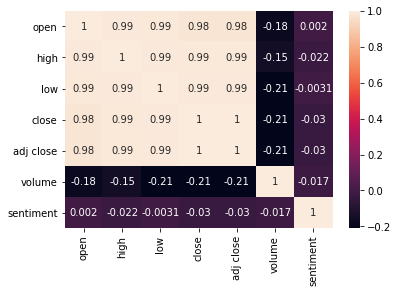

In [15]:
# Check correlation between sentiment and stock prices
sns.heatmap(samsung_stock_sentiment.corr(),annot=True)

In [16]:
samsung_stock_sentiment.to_csv('./dataset/samsung_stock_sentiment.csv')

In [17]:
# For this project, I'll only focus on 'close' price. 
samsung_stock_sentiment.drop(columns=['open','high','low','adj close','volume'],inplace=True)

In [18]:
# Same day data is used for price and sentiment because the stock market is assumed to adjust timely to public sentiments
samsung_stock_sentiment

,date,close,sentiment
0,11/2/2020,986,0.101022
1,12/2/2020,997,0.110758
2,13/2/2020,993,0.120941
3,14/2/2020,1020,0.118883
4,17/2/2020,1018,0.079630
5,18/2/2020,983,0.109610
6,19/2/2020,996,0.112777
7,20/2/2020,960,0.207237
8,21/2/2020,954,0.113513
9,24/2/2020,891,0.215431


In [19]:
X=samsung_stock_sentiment['sentiment'].values.reshape(-1,1)
y=samsung_stock_sentiment['close'].values.reshape(-1,1)

In [20]:
#baseline
y_mean=y.mean()
y_mean

835.4883720930233

In [21]:
# Split test and train data manually to ensure that the first 32 data points are used for training and next 11 data points are for test
X_train=samsung_stock_sentiment['sentiment'][0:32].values.reshape(-1,1)
y_train=samsung_stock_sentiment['close'][0:32].values.reshape(-1,1)
X_test=samsung_stock_sentiment['sentiment'][32::].values.reshape(-1,1)
y_test=samsung_stock_sentiment['close'][32::].values.reshape(-1,1)

## Linear Regression

In [40]:
lr = LinearRegression()
lr.fit(X_train, y_train)
print('Linear regression intercept: ', lr.intercept_)
print('Linear regression gradient: ',lr.coef_)
y_test_pred=lr.predict(X_test)
y_train_pred=lr.predict(X_train)
r2_train=metrics.r2_score(y_train, y_train_pred)
r2_test=metrics.r2_score(y_test, y_test_pred)
print('r2 value for training data: ', r2_train)
print('r2 value for test data:, ', r2_test)
df=pd.DataFrame({'Actual':y_test.flatten(), 'Predicted':y_test_pred.flatten()})
df

Linear regression intercept:  [828.31856995]
Linear regression gradient:  [[282.76321874]]
r2 value for training data:  0.04151425863674452
r2 value for test data:,  -16.657776171629145


,Actual,Predicted
0,794,866.168783
1,736,872.684119
2,765,868.895092
3,759,882.159829
4,720,909.919322
5,740,887.562177
6,748,880.099584
7,775,874.080969
8,806,859.948464
9,805,913.025005


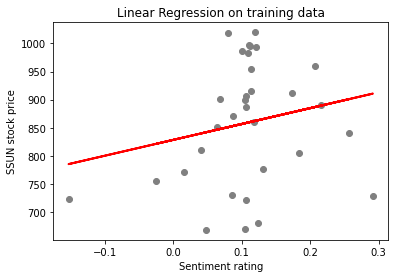

In [44]:
plt.scatter(X_train,y_train,  color='gray')
plt.plot(X_train, y_train_pred, color='red',linewidth=2)
plt.gca().set(ylabel='SSUN stock price', xlabel='Sentiment rating')
plt.title('Linear Regression on training data')
plt.show()

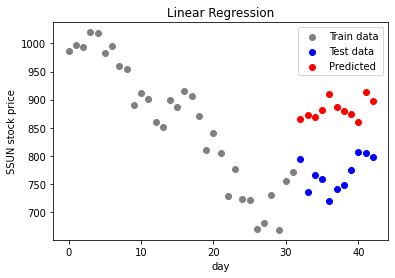

In [45]:
plt.scatter(range(len(y_train)),y_train,  color='gray')
plt.scatter(range(32,43),y_test,  color='blue')
plt.scatter(range(32,43),y_test_pred,  color='red')
plt.gca().set(ylabel='SSUN stock price', xlabel='day')
plt.title('Linear Regression')
plt.gca().legend(('Train data','Test data','Predicted'))
plt.show()

In [26]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_test_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_test_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))

Mean Absolute Error: 115.17448444392193
Mean Squared Error: 14510.897780182773
Root Mean Squared Error: 120.461187858093


## Logistic Regression

In [47]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
#print('Linear regression intercept: ', lr.intercept_)
#print('Linear regression gradient: ',lr.coef_)
y_test_pred=lr.predict(X_test)
y_train_pred=lr.predict(X_train)
r2_train=metrics.r2_score(y_train, y_train_pred)
r2_test=metrics.r2_score(y_test, y_test_pred)
print('r2 value for training data: ', r2_train)
print('r2 value for test data:, ', r2_test)
df=pd.DataFrame({'Actual':y_test.flatten(), 'Predicted':y_test_pred.flatten()})
df

r2 value for training data:  -1.4609190534173329
r2 value for test data:,  -1.929321372541132


C:\Users\frl\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Actual,Predicted
0,794,728
1,736,728
2,765,728
3,759,728
4,720,728
5,740,728
6,748,728
7,775,728
8,806,728
9,805,728


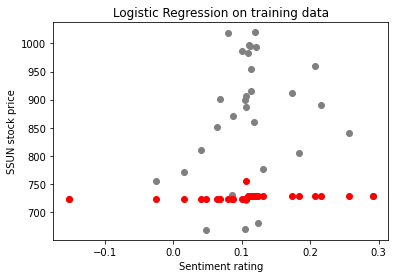

In [48]:
plt.scatter(X_train,y_train,  color='gray')
plt.scatter(X_train, y_train_pred, color='red')
plt.gca().set(ylabel='SSUN stock price', xlabel='Sentiment rating')
plt.title('Logistic Regression on training data')
plt.show()

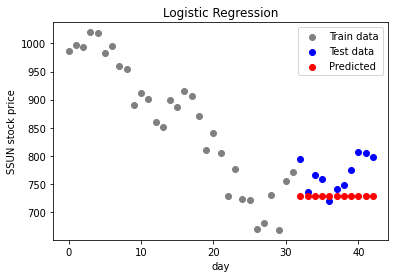

In [49]:
plt.scatter(range(len(y_train)),y_train,  color='gray')
plt.scatter(range(32,43),y_test,  color='blue')
plt.scatter(range(32,43),y_test_pred,  color='red')
plt.gca().set(ylabel='SSUN stock price', xlabel='day')
plt.title('Logistic Regression')
plt.gca().legend(('Train data','Test data','Predicted'))
plt.show()

In [30]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_test_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_test_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))

Mean Absolute Error: 41.27272727272727
Mean Squared Error: 2407.2727272727275
Root Mean Squared Error: 49.06396567005899


## Random Forest

In [50]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

C:\Users\frl\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [51]:
y_test_pred=rf.predict(X_test)
y_train_pred=rf.predict(X_train)
r2_train=metrics.r2_score(y_train, y_train_pred)
r2_test=metrics.r2_score(y_test, y_test_pred)
print('r2 value for training data: ', r2_train)
print('r2 value for test data:, ', r2_test)
df=pd.DataFrame({'Actual':y_test.flatten(), 'Predicted':y_test_pred.flatten()})
df

r2 value for training data:  0.849188507597014
r2 value for test data:,  -11.835983653807476


,Actual,Predicted
0,794,774.83
1,736,857.95
2,765,774.83
3,759,844.77
4,720,777.39
5,740,925.69
6,748,844.77
7,775,863.27
8,806,990.33
9,805,777.39


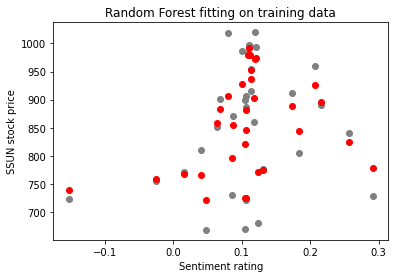

In [52]:
plt.scatter(X_train,y_train,  color='gray')
plt.scatter(X_train, y_train_pred, color='red')
plt.gca().set(ylabel='SSUN stock price', xlabel='Sentiment rating')
plt.title('Random Forest fitting on training data')
plt.show()

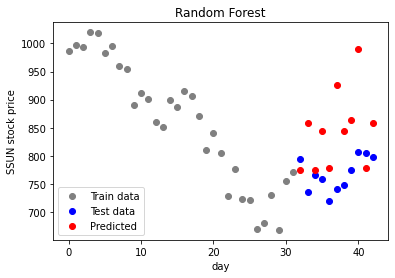

In [53]:
plt.scatter(range(len(y_train)),y_train,  color='gray')
plt.scatter(range(32,43),y_test,  color='blue')
plt.scatter(range(32,43),y_test_pred,  color='red')
plt.gca().set(ylabel='SSUN stock price', xlabel='day')
plt.title('Random Forest')
plt.gca().legend(('Train data','Test data','Predicted'))
plt.show()

In [402]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_test_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_test_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))

Mean Absolute Error: 85.49363636363637
Mean Squared Error: 10250.554863636366
Root Mean Squared Error: 101.24502389567779


## Random Forest with gridsearch

In [54]:
rf = RandomForestRegressor()

In [55]:
rf_params = {
    'n_estimators' : [1000],
    'max_depth' : [3,4],
    'min_samples_leaf': [3,4],
}

In [56]:
gs_rf = GridSearchCV(rf,param_grid=rf_params,cv=5)
gs_rf.fit(X_train, y_train)

C:\Users\frl\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\frl\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\frl\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\frl\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [57]:
print("\nThe best params are: \n{}".format(gs_rf.best_params_))


The best params are: 
{'max_depth': 4, 'min_samples_leaf': 3, 'n_estimators': 1000}


In [58]:
y_test_pred=gs_rf.predict(X_test)
y_train_pred=gs_rf.predict(X_train)
r2_train=metrics.r2_score(y_train, y_train_pred)
r2_test=metrics.r2_score(y_test, y_test_pred)
print('r2 value for training data: ', r2_train)
print('r2 value for test data:, ', r2_test)
df=pd.DataFrame({'Actual':y_test.flatten(), 'Predicted':y_test_pred.flatten()})
df

r2 value for training data:  0.4786569636828887
r2 value for test data:,  -7.484694315943669


,Actual,Predicted
0,794,828.993033
1,736,827.031352
2,765,828.993033
3,759,823.458371
4,720,835.412189
5,740,840.081445
6,748,823.458371
7,775,827.136638
8,806,963.684194
9,805,835.412189


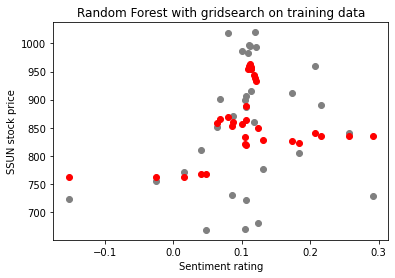

In [59]:
plt.scatter(X_train,y_train,  color='gray')
plt.scatter(X_train, y_train_pred, color='red')
plt.gca().set(ylabel='SSUN stock price', xlabel='Sentiment rating')
plt.title('Random Forest with gridsearch on training data')
plt.show()

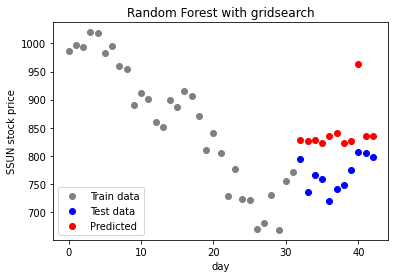

In [60]:
plt.scatter(range(len(y_train)),y_train,  color='gray')
plt.scatter(range(32,43),y_test,  color='blue')
plt.scatter(range(32,43),y_test_pred,  color='red')
plt.gca().set(ylabel='SSUN stock price', xlabel='day')
plt.title('Random Forest with gridsearch')
plt.gca().legend(('Train data','Test data','Predicted'))
plt.show()